# ECCITE-seq ctrl protein acceleration analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import velocyto as vcy
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import pa

Import protein count data. Acquired from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3596096, file **GSM3596096_ctrl-ADT-count.csv.gz**.


In [3]:
[prot_count_array,prot_cells,adt_names] = pa.import_prot_data( \
    '/data/hoan/sc_velocity/data/GSM3596096_ctrl-ADT-count.csv')

Display proteins with available data. 

In [4]:
print(adt_names)

['B220 (CD45R)' 'B7-H1 (PD-L1)' 'C-kit (CD117)' 'CCR7' 'CD11b' 'CD11c'
 'CD138' 'CD14' 'CD16' 'CD19' 'CD1a' 'CD2' 'CD223 (lag3)' 'CD24'
 'CD26 (Adenosine)' 'CD27' 'CD28' 'CD3' 'CD34' 'CD366 (tim3)' 'CD4' 'CD44'
 'CD45' 'CD45RA' 'CD45RO' 'CD5' 'CD56' 'CD62L' 'CD66b' 'CD69' 'CD7' 'CD77'
 'CD8' 'CTLA4' 'EpCAM (CD326)' 'HLA-A,B,C' 'IL7Ralpha (CD127)' 'IgG1'
 'IgG2a' 'LAMP1' 'MHCII (HLA-DR)' 'Ox40 (CD134)' 'PD-1 (CD279)'
 'PD-L1 (CD274)' 'PD1 (CD279)' 'PECAM (CD31)' 'Siglec-8' 'TCRb' 'TCRg'
 'bad_struct' 'no_match' 'total_reads']


`velocyto` processing:
`velocyto run (BAM directory)/(BAM file.bam) (transcriptome directory)/genes/genes.gtf`



Import `velocyto` command-line interface (CLI) pipeline output.

In [5]:
vlm = vcy.VelocytoLoom("/data/hoan/sc_velocity/data/190426_ctrl.loom")

Select 3000 genes with highest variability.

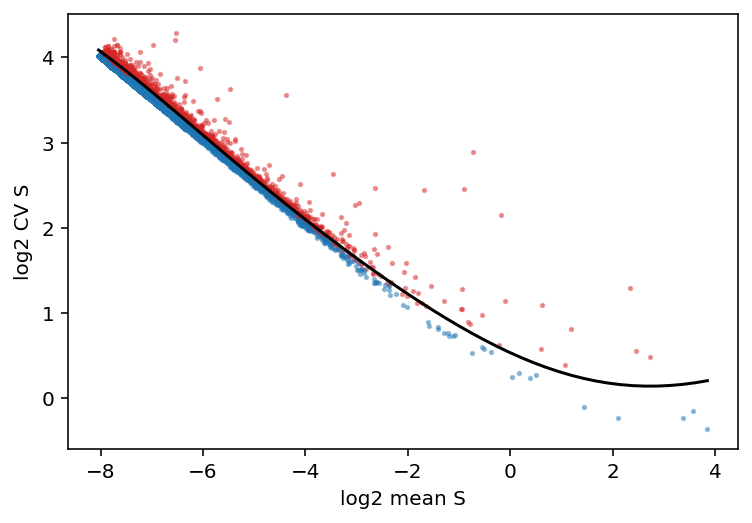

In [6]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=100, min_expr_cells=20)
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)

Define relationship between proteins and source mRNA. 

In [7]:
gene_dict = {'B220 (CD45R)':['PTPRC'], 'B7-H1 (PD-L1)':['CD274'],  'C-kit (CD117)':['KIT'], 'CCR7':['CCR7'], 'CD11b':['ITGAM'], 'CD11c':['ITGAX'], 'CD138':['SDC1'], 'CD14':['CD14'], 'CD16':['FCGR3A'], 'CD19':['CD19'], 'CD1a':['CD1A'], 'CD2':['CD2'], 'CD223 (lag3)':['LAG3'],  'CD26 (Adenosine)':['DPP4'], 'CD27':['CD27'], 'CD28':['CD28'], 'CD3':['CD3E'], 'CD34':['CD34'], 'CD366 (tim3)':['HAVCR2'], 'CD4':['CD4'], 'CD44':['CD44'], 'CD45':['PTPRC'], 'CD45RA':['PTPRC'], 'CD45RO':['PTPRC'], 'CD5':['CD5'], 'CD56':['NCAM1'], 'CD62L':['SELL'], 'CD66b':['CEACAM8'], 'CD69':['CD69'], 'CD7':['CD7'],  'CD8':['CD8A'], 'CTLA4':['CTLA4'], 'EpCAM (CD326)':['EPCAM'], 'HLA-A,B,C':['HLA-A'], 'IL7Ralpha (CD127)':['IL7R'],   'LAMP1':['LAMP1'], 'MHCII (HLA-DR)':['HLA-DRA'], 'Ox40 (CD134)':['TNFRSF4'], 'PD-1 (CD279)':['PDCD1'], 'PD-L1 (CD274)':['CD274'], 'PD1 (CD279)':['PDCD1'],  'Siglec-8':['SIGLEC8']}

InvertDict = lambda d: dict( (v,k) for k in d for v in d[k] )


Define inverse relationship.

In [8]:
prot_dict = InvertDict(gene_dict)
mrna_targets = list(prot_dict.keys())

Append genes that yield observed proteins even if variability is relatively low for RNA velocity phase plots. Filter genes. Save ADT names.

In [9]:
pa.enforce_protein_filter(vlm,mrna_targets,adt_names)

In [10]:
vlm.filter_genes(by_cv_vs_mean=True,by_detection_levels=True)

Check format of intersection cell IDs. Filter for intersection of cell UMIs. 

In [11]:
vlm.ca['CellID'][0]

'190426_ctrl:AAACCTGGTAAACGCGx'

In [12]:
first_char = vlm.ca['CellID'][0].find(':')+1
last_char = -1

[prot_count_array, shared_cells, prot_cells] = pa.shared_cells_filter(vlm, prot_cells, prot_count_array, first_char, last_char)

ADT cell number: 6500
RNAseq cell number: 5530
Shared cells: 5084
Shared cells with more than 5 molecules: 5064


Perform knn imputation using protein space (more robust due to higher counts, less subject to the curse of dimensionality due to low number of quantified proteins vs. RNA).

In [13]:
#pa.impute(vlm, prot_count_array, k=800, impute_in_prot_space=True, size_norm=False, impute_in_pca_space=False)
pa.impute(vlm, prot_count_array, k=30, impute_in_prot_space=True, size_norm=False, impute_in_pca_space=False)

Find clusters in protein space in order to ID cell types.

In [14]:
t_cl =  [0, 1, 0, 3, 2, 2, 1, 3, 2, 1]
[cluster_ID, num_clusters] = pa.identify_clusters(vlm,vlm.connectivity,
                                                  correct_tags=True,tag_correction_list=t_cl,
                                                  method_name='RBERVertexPartition')

In [15]:
num_clusters

4

In [16]:
COLORS=np.asarray([ [0.8500, 0.3250, 0.0980], #CD8
                    [0, 0.4470, 0.7410], #CD4
                    [0.4660, 0.6740, 0.1880], #NK
                    [0.4940, 0.1840, 0.5560] #Mono
                  ])
cluster_labels = ["CD8+ T", "CD4+ T", "NK", "B/Mono."]
vlm.COLORS = COLORS
vlm.labels=cluster_labels

Visualize clusters 

In [17]:
#pa.fit_pcs(vlm,'P_norm','prot_pcs',n_pcs=4)

In [18]:
pa.fit_pcs(vlm,'P_norm','prot_pcs',n_pcs=10)
pa.fit_tsne(vlm, 'prot_pcs', 'prot_tsne', 10, seed=20)

<Figure size 1080x720 with 0 Axes>

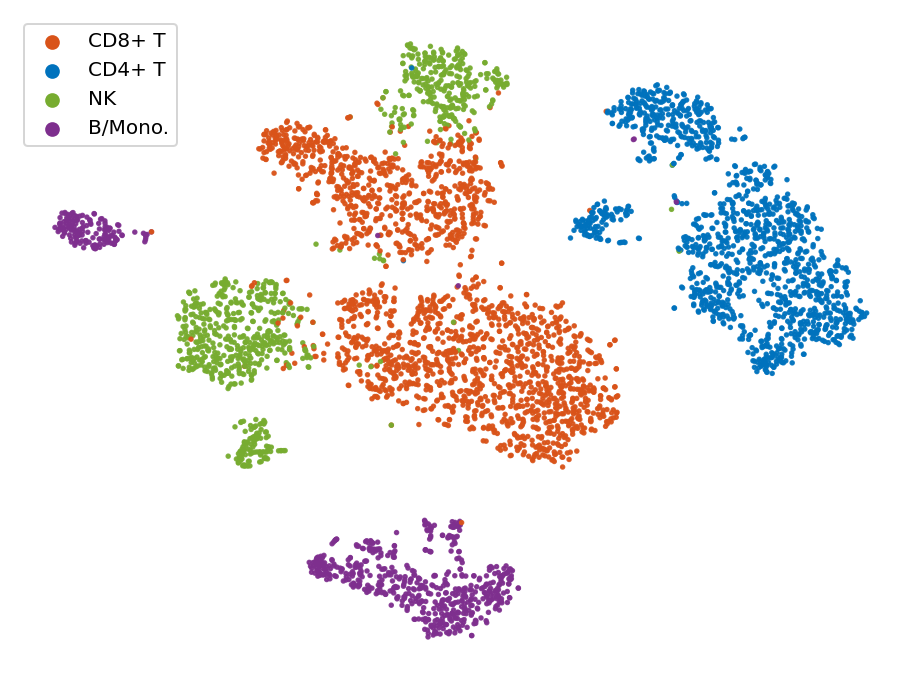

In [19]:
#cluster_labels = [0, 1, 0, 3, 2, 2, 1, 3, 2, 1]
plt.figure(figsize=(15,10))
pa.visualize_pcs(vlm, [1,2], 'prot_tsne')

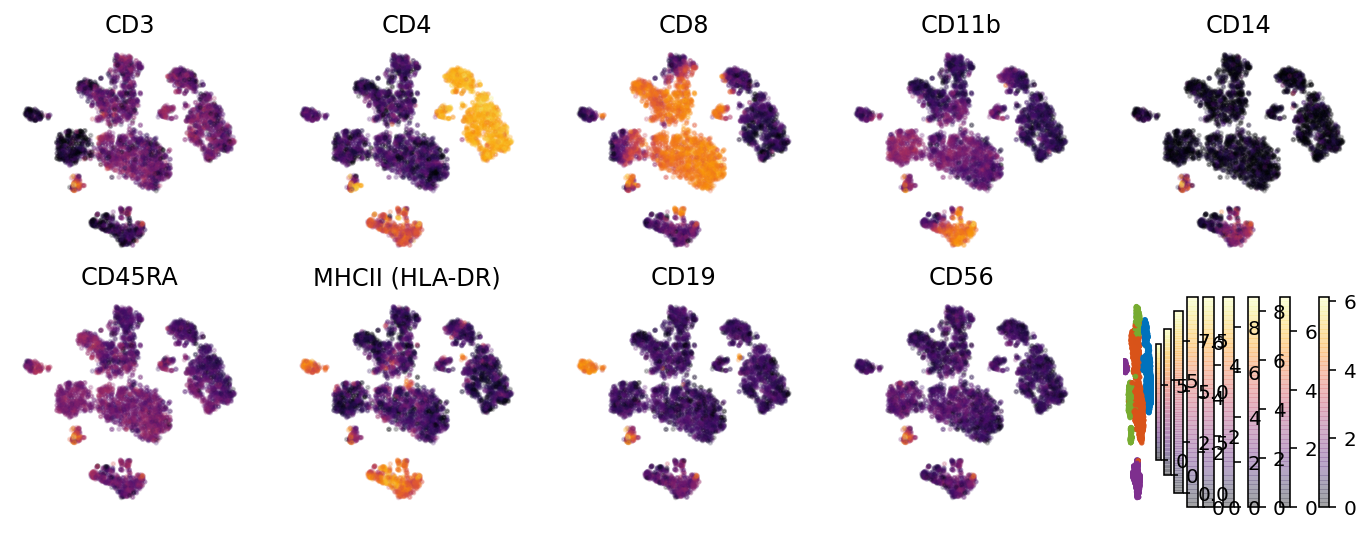

In [20]:
from joint_velo import *
marker_list =  ['CD3','CD4','CD8','CD11b','CD14','CD45RA','MHCII (HLA-DR)','CD19','CD56']
visualize_protein_markers_tsne(vlm, protein_markers=marker_list, pc_targets=[1,2], visualize_clusters= True)
#plt.savefig("fig/ecc_ctrl_clus.svg")

Visualize phase portraits.

In [21]:
mrna_targets = list(set(mrna_targets).intersection(set(vlm.ra['Gene'])))

In [22]:
#pa.visualize_phase_portraits(vlm, mrna_targets, target='protein', imputed=True, prot_dict=prot_dict)

Manually select RNA/protein pairs with reasonably diagonal plots for protein velocity.

In [23]:
genes_used_for_prot_velocity =  ['ITGAX','CD2','CD27','CD28',
                'CD3E','CD5','SELL','CD7','CD8A','IL7R','HLA-DRA']
adt_used_for_prot_velocity = ['CD11c','CD2','CD27','CD28',
                 'CD3','CD5','CD62L','CD7','CD8','IL7Ralpha (CD127)','MHCII (HLA-DR)']

Perform PCA embedding reduction in spliced space for embedding.

In [24]:
target_size_median = [np.median(vlm.S.sum(0)), np.median(vlm.U.sum(0))]
vlm.normalize(which="both",size=True,target_size=target_size_median)
pa.fit_pcs(vlm,'S_norm','pcs',3)

In [25]:
#pa.visualize_pcs(vlm, [1,2], pc_space='pcs')
#pa.visualize_pcs(vlm, [2,3], pc_space='pcs')

Fit degradation parameters; extrapolate.

In [26]:
pa.gamma_fit(vlm,'Sx','Ux','rna')
pa.extrapolate(vlm,vel_type='rna')

/home/vanhoan310/miniconda3/envs/tsne/lib/python3.7/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


In [27]:
pa.gamma_fit(vlm,'Px','Sx','protein',genes_used_for_prot_velocity, adt_used_for_prot_velocity)
pa.extrapolate(vlm,vel_type='protein')

Examine parameter fits. 

In [28]:
n_rna_velo_fit_viz = 24
np.random.seed(123)
print(str(len(vlm.rna_velo_gene_ind))+' spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying '\
      +str(n_rna_velo_fit_viz)+' random phase portraits:')
genes_for_rna_velo_fit=np.random.choice(vlm.rna_velo_gene_ind,n_rna_velo_fit_viz,replace=False)

80 spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying 24 random phase portraits:


In [29]:
rna_vel_genes=vlm.ra['Gene'][genes_for_rna_velo_fit]
#pa.visualize_phase_portraits(vlm, rna_vel_genes, target='mrna', plot_fit=True)
#plt.savefig("fig/ecc_ctrl_rnaphase.svg")

In [30]:
#pa.visualize_phase_portraits(vlm, mrna_targets, target='protein', imputed=True, prot_dict=prot_dict, plot_fit=True)
#plt.savefig("fig/ecc_ctrl_protphase.svg")

Project velocity direction into the embedding using the transition matrix method.

In [31]:
pa.identify_embedding_knn(vlm,'pcs',[0,1])

In [32]:
pa.calculate_embedding_delta(vlm,'Sx','delta_S','delta_S_in_S_pca','rna_velo_gene_ind')

In [33]:
#pa.visualize_velocity_projection(vlm, 'delta_S_in_S_pca')

In [34]:
pa.calculate_embedding_delta(vlm,'Px','delta_P','delta_P_in_S_pca','prot_velo_prot_ind')

In [35]:
#pa.visualize_velocity_projection(vlm, 'delta_P_in_S_pca')

Visualize cluster-specific velocities.

In [36]:
# pa.cluster_specific_plot(vlm, 'delta_S_in_S_pca',draw_cells=True)

In [37]:
# pa.cluster_specific_plot(vlm, 'delta_P_in_S_pca',draw_cells=True)

Prepare and perform grid embedding.

In [38]:
pa.initialize_grid_embedding(vlm)
uv_multiplier=0.8
pa.calculate_grid_arrows(vlm,'delta_S_in_S_pca', '_rna', min_mass=1,uv_multiplier=uv_multiplier)
pa.calculate_grid_arrows(vlm,'delta_P_in_S_pca', '_prot', min_mass=1,uv_multiplier=uv_multiplier)

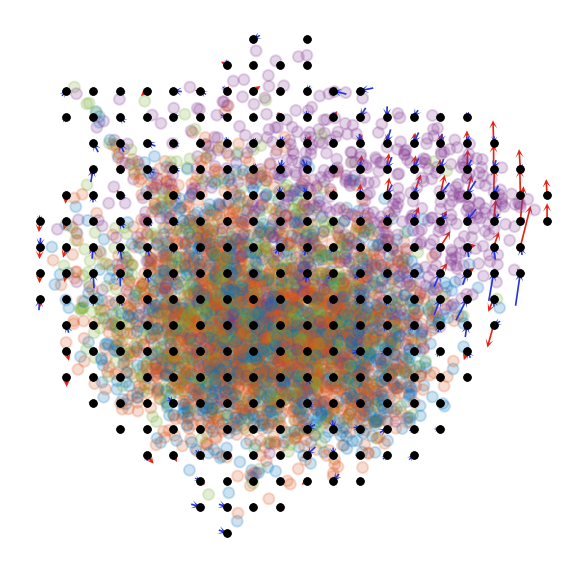

In [39]:
r_rnav = [231/255,36/255,20/255]
b_protv = [38/255,55/255,213/255]
plt.figure(figsize=(5,5))
pa.plot_grid_arrows(vlm,'UV_rna',plot_cells=False, arr_col=r_rnav)
pa.plot_grid_arrows(vlm,'UV_prot',plot_cells=True, arr_col=b_protv, color_cells_by_cluster=True, pivot='tip',cell_alpha=0.2)

In [40]:
#plt.figure(figsize=(15,15))
#pa.plot_bezier(vlm, plot_cells=True, color_cells_by_cluster=True,cell_alpha=0.2,arr_len_scal=0.09)

Calculate t-SNE embedding based on normalized spliced counts. Perform analysis in t-SNE space. 

In [41]:
n_pcs_S = 25
n_pcs_P = 10
pa.fit_pcs(vlm,'S_norm','pcs_S',n_pcs_S)
pa.fit_pcs(vlm,'P_norm','pcs_P',n_pcs_P)

In [42]:
from sklearn.manifold import TSNE, JTSNE
def fit_jointTSNE(vlm, pc_space_name1, pc_space_name2, n_pcs1, n_pcs2, ts_name, init = 'pca', seed=None):
    #bh_tsne = TSNE(random_state=seed)
    data = {'X1': getattr(vlm,pc_space_name1)[:, :n_pcs1], 'X2': getattr(vlm,pc_space_name2)[:, :n_pcs2]}
    bh_tsne = JTSNE(init = init, random_state = seed).fit_transform(X = data, method = 'auto', _lambda = 3)
    setattr(vlm,ts_name,bh_tsne)

In [43]:
fit_jointTSNE(vlm, 'pcs_P','pcs_S', n_pcs_P,  n_pcs_S,'tsne')

In [44]:
pa.identify_embedding_knn(vlm,'tsne',[0,1])

In [45]:
pa.calculate_embedding_delta(vlm,'Sx','delta_S','delta_S_in_S_tsne','rna_velo_gene_ind')

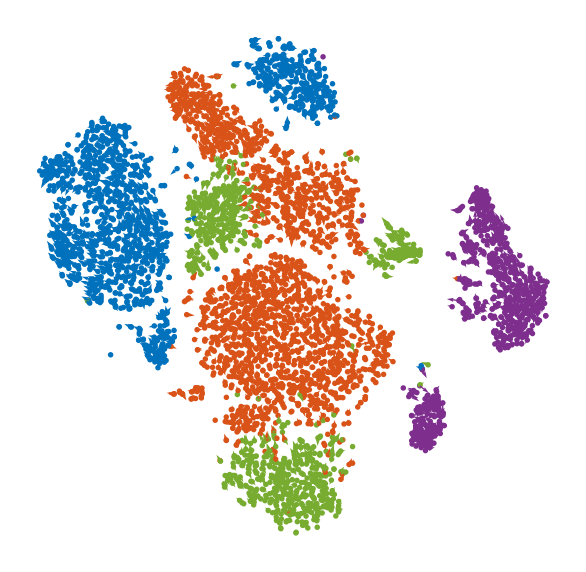

In [46]:
plt.figure(figsize=(5,5))
pa.visualize_velocity_projection(vlm, 'delta_S_in_S_tsne')

In [47]:
pa.calculate_embedding_delta(vlm,'Px','delta_P','delta_P_in_S_tsne','prot_velo_prot_ind')

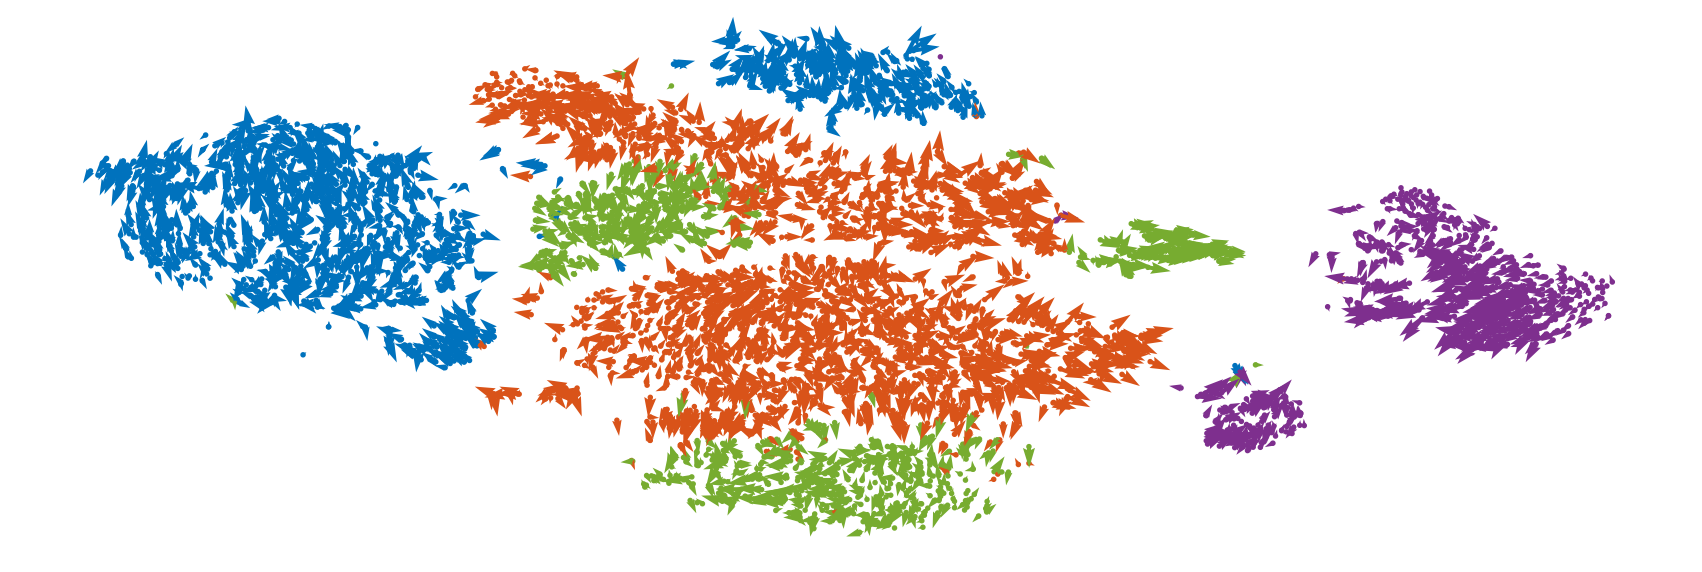

In [48]:
plt.figure(figsize=(15,5))
pa.visualize_velocity_projection(vlm, 'delta_P_in_S_tsne')

Visualize cluster-specific velocities.


In [49]:
#pa.cluster_specific_plot(vlm, 'delta_S_in_S_tsne',draw_cells=True)
#plt.savefig("fig/ecc_ctrl_rnav.svg")

In [50]:
#pa.cluster_specific_plot(vlm, 'delta_P_in_S_tsne',draw_cells=True)
#plt.savefig("fig/ecc_ctrl_protv.svg")

Prepare and perform grid embedding.

In [59]:
if hasattr(vlm,'mass_filter'):
    delattr(vlm,'mass_filter')
pa.initialize_grid_embedding(vlm, n_neighbors=20)
uv_multiplier=3
pa.calculate_grid_arrows(vlm,'delta_S_in_S_tsne', '_rna', min_mass=0.5,uv_multiplier=uv_multiplier+3)
pa.calculate_grid_arrows(vlm,'delta_P_in_S_tsne', '_prot', min_mass=0.5,uv_multiplier=uv_multiplier)

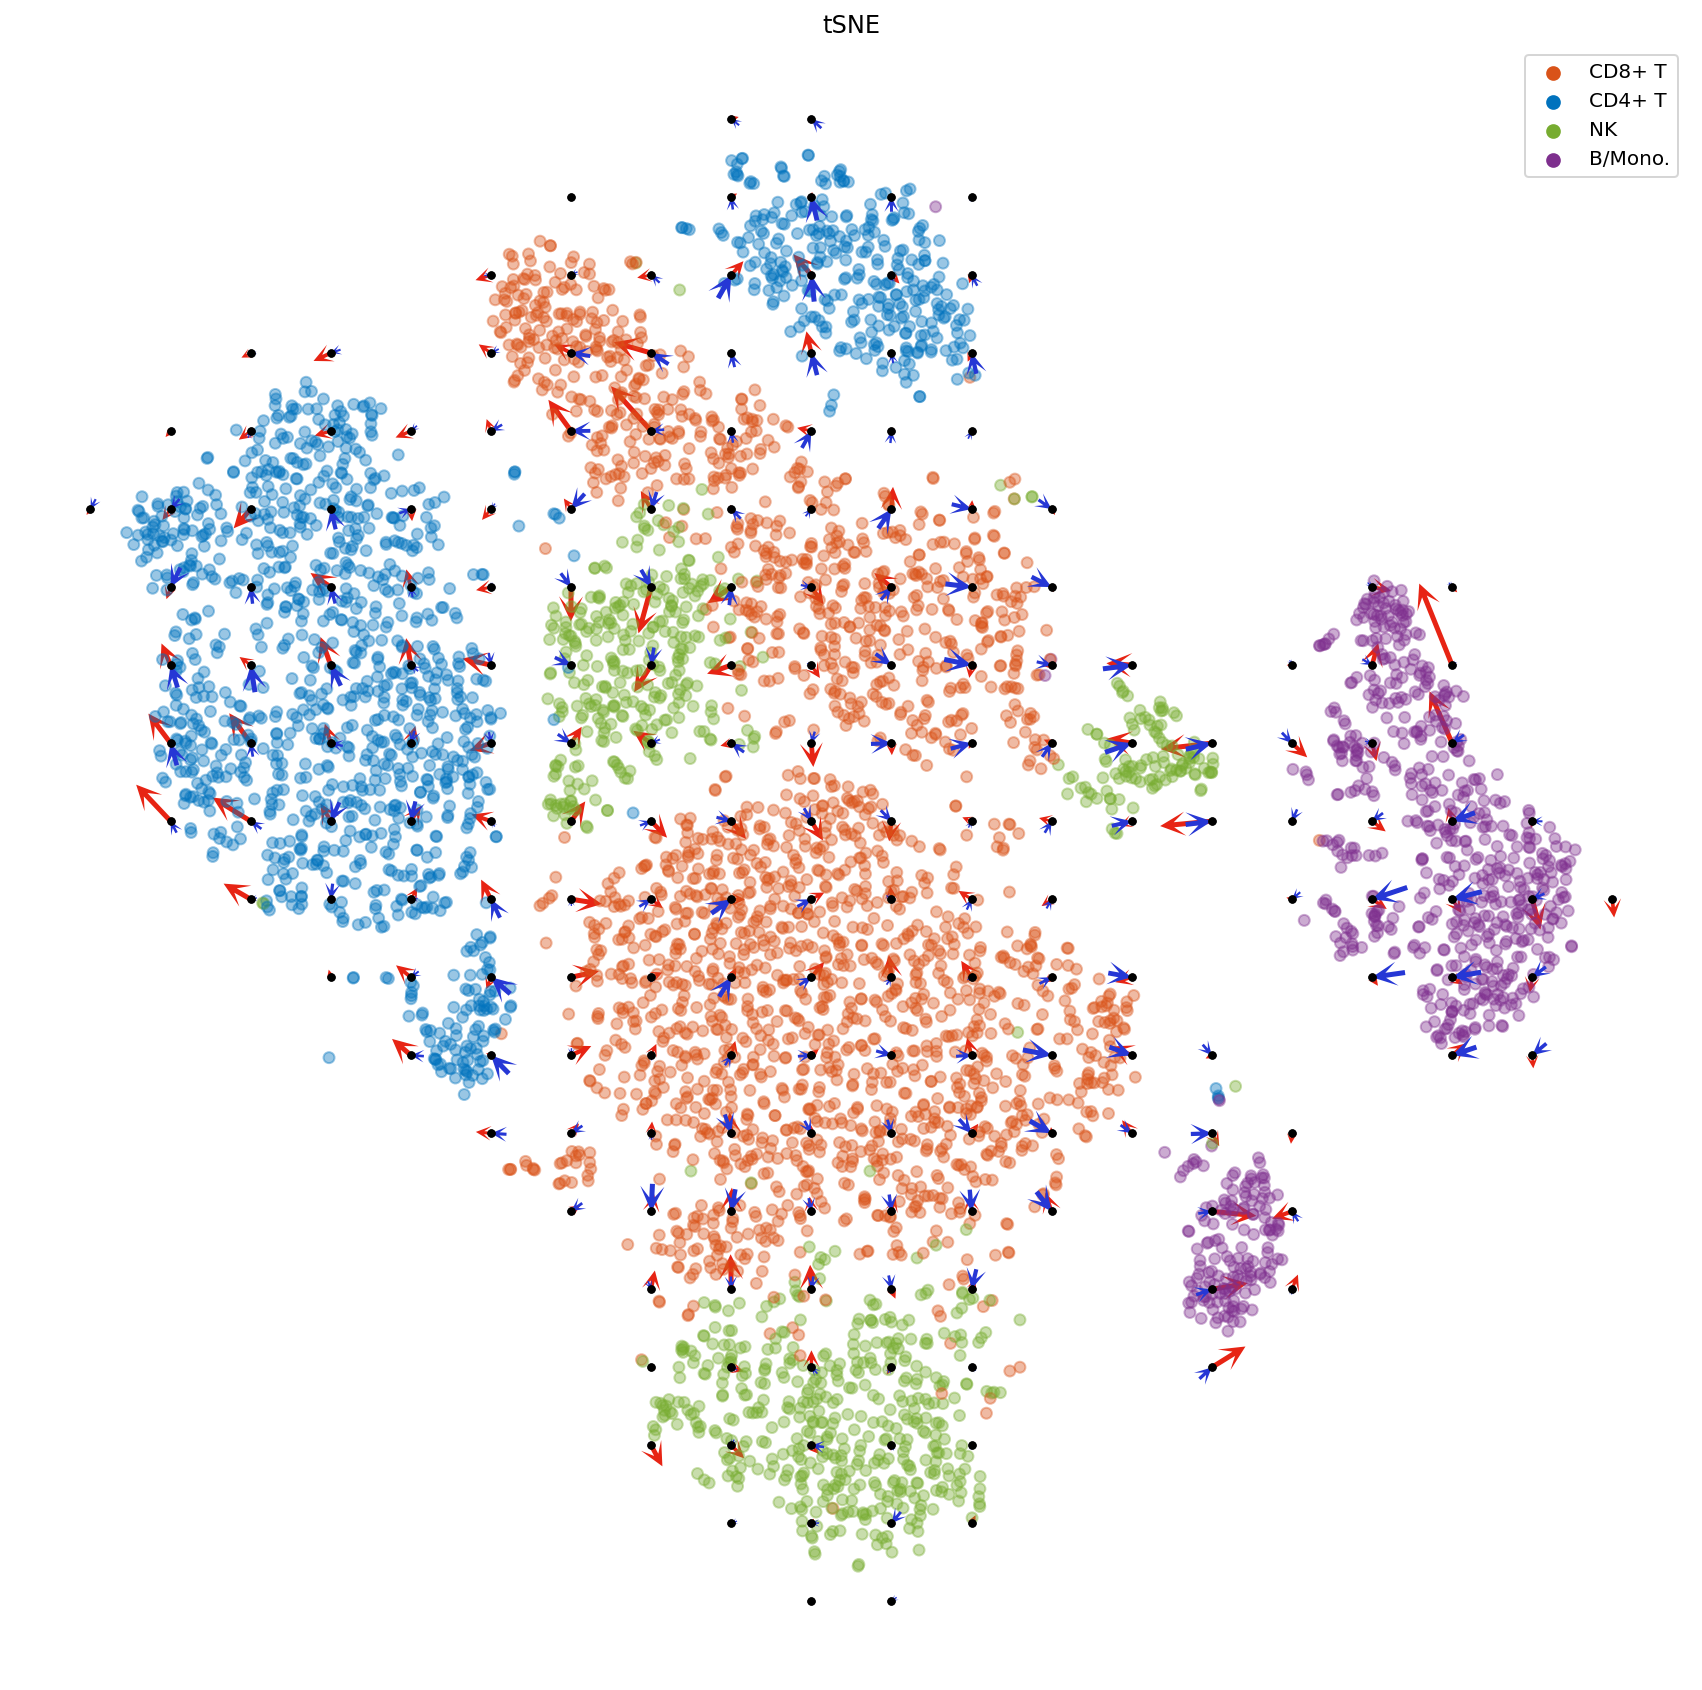

In [62]:
r_rnav = [231/255,36/255,20/255]
b_protv = [38/255,55/255,213/255]
plt.figure(figsize=(15,15))
pa.plot_grid_arrows(vlm,'UV_rna',plot_cells=False, arr_col=r_rnav,arr_scale=1)
pa.plot_grid_arrows(vlm,'UV_prot',plot_cells=True, arr_col=b_protv, color_cells_by_cluster=True, 
                    pivot='tip',cell_alpha=0.4, arr_scale=1,write_labels=True)
#plt.savefig("fig/ecc_ctrl_comb.svg")
plt.title("tSNE")
plt.savefig("/data/hoan/plots/eccite_tsne.pdf")

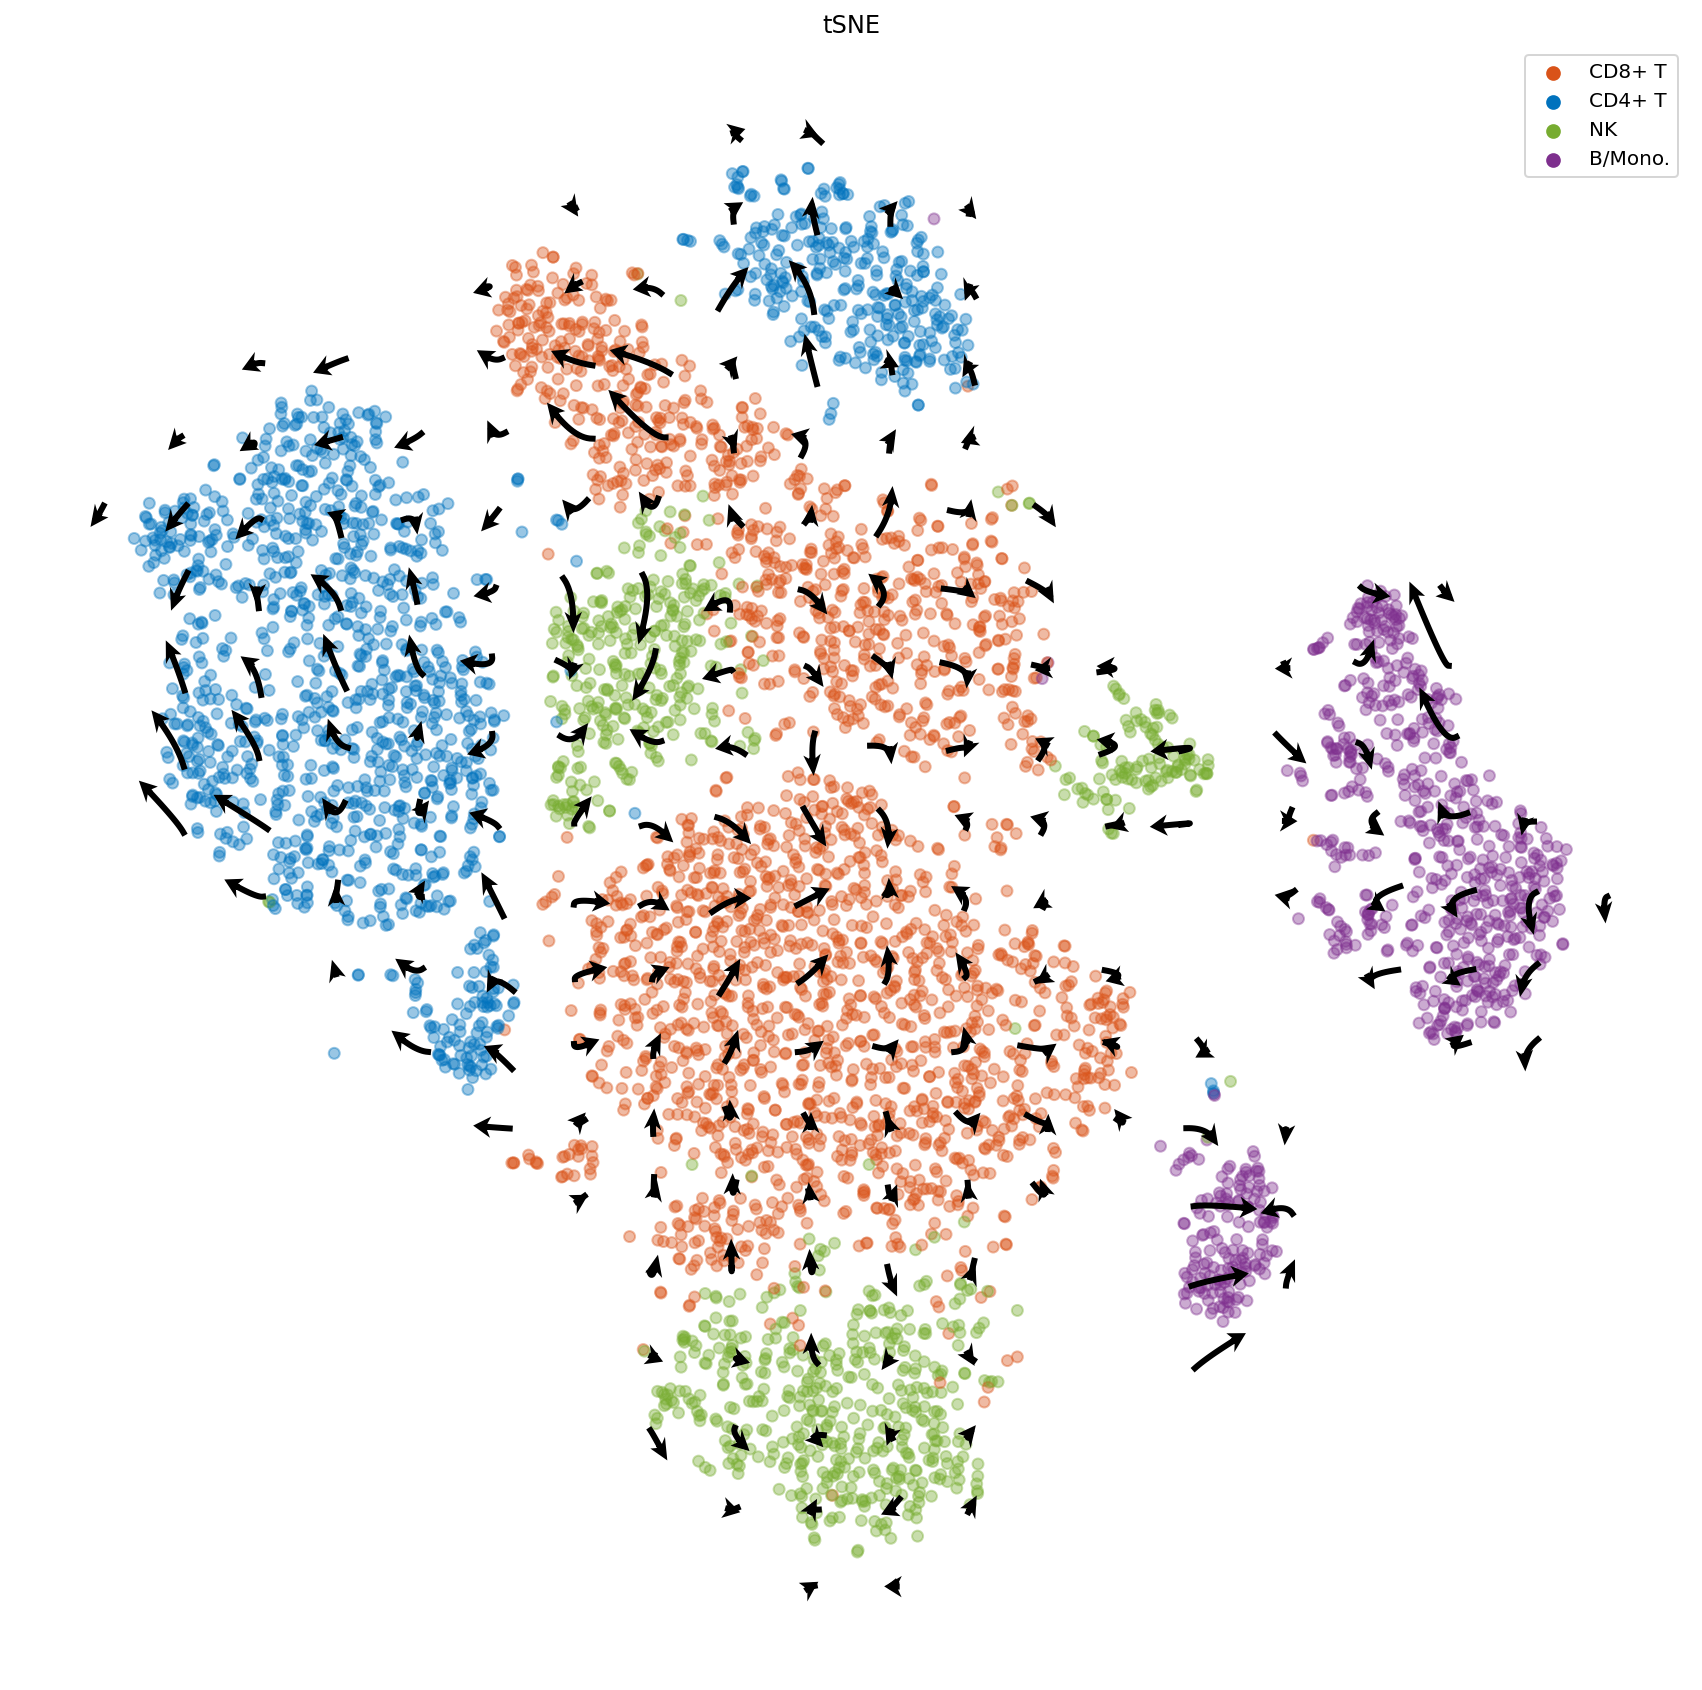

In [63]:
%reload_ext autoreload
%autoreload 2
import pa
plt.figure(figsize=(15,15))
pa.plot_bezier(vlm, plot_cells=True, color_cells_by_cluster=True, arr_len_scal=1.2,cell_alpha=0.4,write_labels=True)
#plt.savefig("fig/ecc_ctrl_bez.svg")
plt.title("tSNE")
plt.savefig("/data/hoan/plots/eccite_bez_tsne.pdf")